In [14]:
import spacy
import pandas as pd
import numpy as np
import re

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

---

## **Первичный анализ данных**

In [15]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/twitter toxic/twitter_toxic_tweets.csv')

In [16]:
data.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


**У нас 3 колонки**
1) Уникальный айди твита
2) Метка эмоционального окраса твита
3) И сам текст твита

In [17]:
# Пропущенные значения
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 id       0
label    0
tweet    0
dtype: int64


**Пропусков нет**

In [18]:
# Распределение меток
print("\n abel Distribution:")
print(data['label'].value_counts())


 abel Distribution:
label
0    29720
1     2242
Name: count, dtype: int64


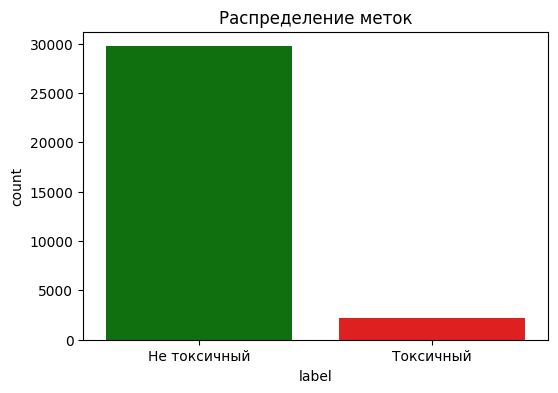

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data, hue='label', palette=['green', 'red'], legend=False)
plt.title("Распределение меток")
plt.xticks([0,1], ['Не токсичный', 'Токсичный'])
plt.show()

**Значительный дисбаланс классов**

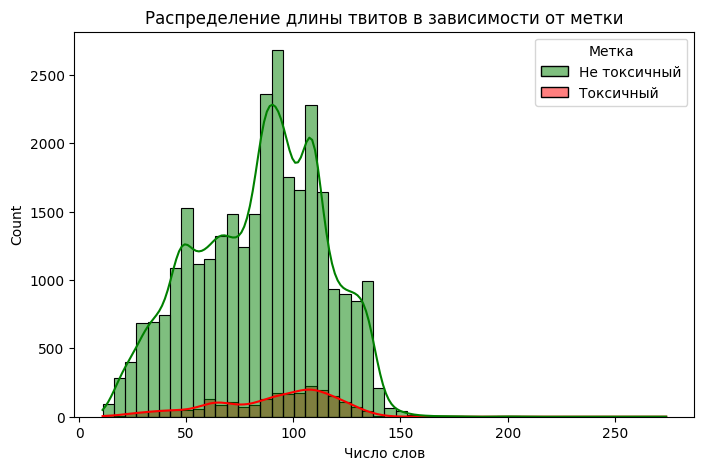

,tweet_length
label,
0,84.328634
1,90.187779


In [20]:
data['tweet_length'] = data['tweet'].apply(len)

plt.figure(figsize=(8,5))
ax = sns.histplot(data=data, x='tweet_length', hue='label', bins=50, kde=True, palette=['green', 'red'])
plt.title("Распределение длины твитов в зависимости от метки")
plt.xlabel("Число слов")

legend = ax.get_legend()
if legend:
    custom_labels = ['Не токсичный', 'Токсичный']
    for t, l in zip(legend.texts, custom_labels):
        t.set_text(l)
    legend.set_title('Метка')

plt.show()

data.groupby('label')['tweet_length'].mean()

**Токсичные твиты в среднем немного длиннее**

---

## **Подготовка текстов для анализа**

Проводим токенизаци с помощью spacy

In [21]:
def clean_with_spacy(text):

    # 1. Предварительная чистка регулярками (ссылки и теги юзеров)
    text = re.sub(r'http\S+|www\S+|@\w+', '', str(text))

    # 2. Прогон через пайплайн spaCy
    doc = nlp(text)

    # 3. Лемматизация и фильтрация
    # token.lemma_ — приведение к начальной форме
    # token.is_stop — проверка на стоп-слово
    # token.is_alpha — проверка, что это буква (убирает знаки препинания и цифры)
    cleaned_tokens = [
        token.lemma_.lower().strip()
        for token in doc
        if token.is_alpha
        and len(token.lemma_) > 1
        and (
            not token.is_stop
            or token.lemma_.lower() in {"no", "not", "never"}
        )
    ]

    return " ".join(cleaned_tokens)

In [22]:
# Применяем ко всему датасету:
data['cleaned_text'] = data['tweet'].apply(clean_with_spacy)

TF-IDF строит словарь по X_train и превращает каждый твит в вектор

In [23]:
# Разбиваем данные на обучающую и тестовую выборки (80/20)
# Используем очищенные данные из предыдущего шага
X = data['cleaned_text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y)

# Инициализируем векторизатор
# max_features=5000 ограничит словарь самыми важными словами (убирает редкие опечатки)
# ngram_range=(1,2) позволит модели видеть не только слова, но и пары слов
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)

# Обучаем векторизатор и трансформируем текст в числа
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [25]:
# Тренируем логистическую регрессию
model = LogisticRegression(class_weight='balanced', max_iter=500)
model.fit(X_train_tfidf, y_train)

# Предсказываем на test
y_pred = model.predict(X_test_tfidf)

# Выводим отчет
print("--- Результат логистической регрессии ---")
print(classification_report(y_test, y_pred))

--- Результат логистической регрессии ---
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      5945
           1       0.48      0.80      0.60       448

    accuracy                           0.93      6393
   macro avg       0.73      0.87      0.78      6393
weighted avg       0.95      0.93      0.93      6393



In [26]:
confusion_matrix(y_test, y_pred)

array([[5556,  389],
       [  88,  360]])

- TN (True Negatives): 5556 — Количество нетоксичных твитов, правильно классифицированных как нетоксичные.
- FP (False Positives): 88 — Нетоксичные твиты, неправильно классифицированные как токсичные (модель "перефлаговала" их).
- FN (False Negatives): 389 — Токсичные твиты, неправильно классифицированные как нетоксичные (модель их пропустила).
- TP (True Positives): 360 — Токсичные твиты, правильно классифицированные как токсичные

Recall(1) = 360 / (360 + 88) ≈ 0.80 -> Модель находит ~80% всех нужных объектов, что довольно хороший показатель

Precision(1) = 360 / (360 + 389) ≈ 0.48 -> почти каждый второй «пойманный» токсичный твит таковым не является.

**Получается, мы находим 80% всех нужных случаев, но половина тревог ложные.**

---

## **Облако слов токсичных и не-токсичных твитов**

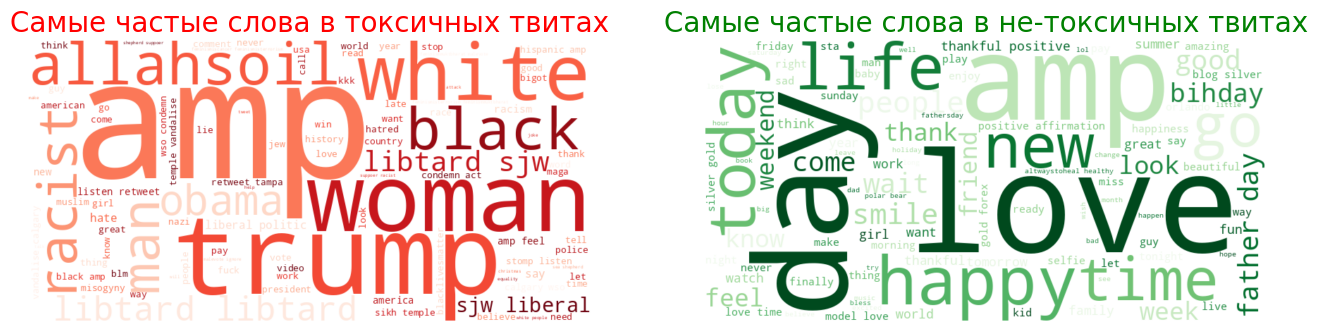

In [31]:
def show_wordclouds(data, column):

    toxic_tweets = data[data['label'] == 1][column].dropna().str.cat(sep=' ')
    clean_tweets = data[data['label'] == 0][column].dropna().str.cat(sep=' ')

    # Настройки облака слов
    wc_params = {
        'width': 800,
        'height': 400,
        'background_color': 'white',
        'max_words': 100
    }

    # Генерируем облака
    wordcloud_toxic = WordCloud(**wc_params, colormap='Reds').generate(toxic_tweets)
    wordcloud_clean = WordCloud(**wc_params, colormap='Greens').generate(clean_tweets)

    plt.figure(figsize=(16, 10))

    # Левый график — Токсичные
    plt.subplot(1, 2, 1)
    plt.imshow(wordcloud_toxic, interpolation='bilinear')
    plt.title('Самые частые слова в токсичных твитах', fontsize=20, color='red')
    plt.axis('off')

    # Правый график — Нетоксичные
    plt.subplot(1, 2, 2)
    plt.imshow(wordcloud_clean, interpolation='bilinear')
    plt.title('Самые частые слова в не-токсичных твитах', fontsize=20, color='green')
    plt.axis('off')

    plt.show()

show_wordclouds(data, 'cleaned_text')

**Похоже, что наиболее токичные темы для твитов связаны с политикой**

---

## **Посмотрим, какие слова сыграли важнейщую роль в классификации**

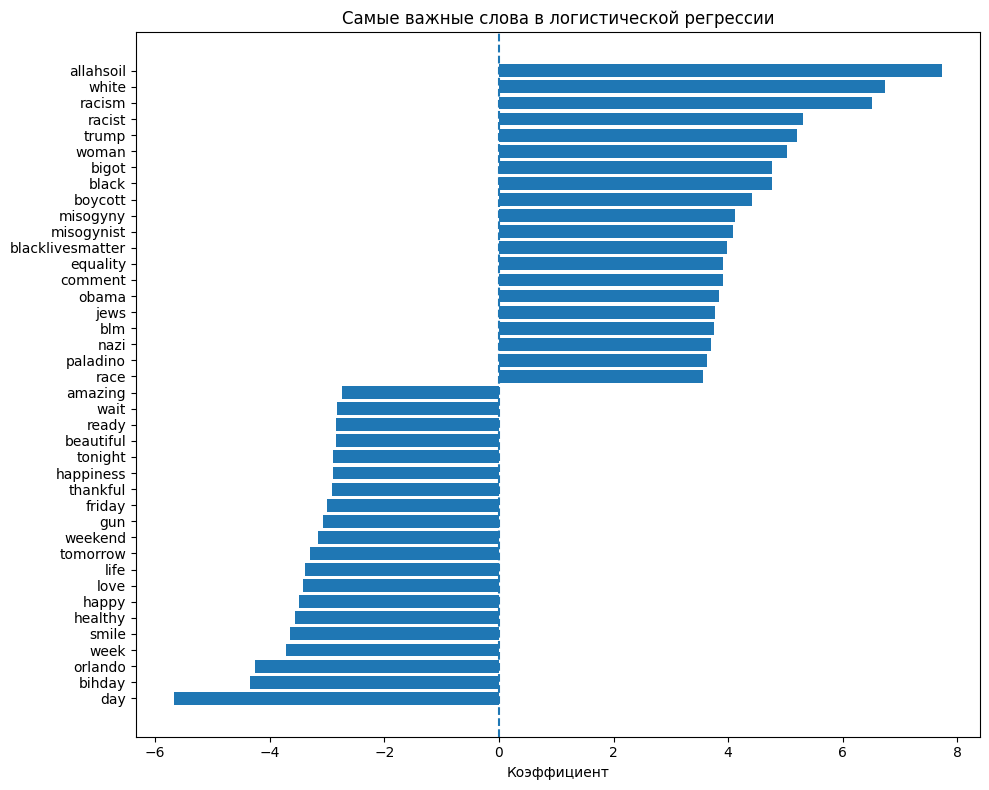

In [30]:
# Получаем имена слов
feature_names = tfidf.get_feature_names_out()

# Коэффициенты логистической регрессии
coefs = model.coef_[0]

# Сортировка по величине коэффициента
top_n = 20

# Самые "негативные" слова (толкают к классу 1)
top_pos_idx = np.argsort(coefs)[-top_n:]

# Самые "позитивные" слова (толкают к классу 0)
top_neg_idx = np.argsort(coefs)[:top_n]

# Объединяем для одного графика
top_idx = np.hstack([top_neg_idx, top_pos_idx])
top_words = feature_names[top_idx]
top_coefs = coefs[top_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_idx)), top_coefs)
plt.yticks(range(len(top_idx)), top_words)
plt.axvline(0, linestyle="--")   # нулевая линия
plt.title("Самые важные слова в логистической регрессии")
plt.xlabel("Коэффициент")
plt.tight_layout()
plt.show()

---

## **ROC-AUC**

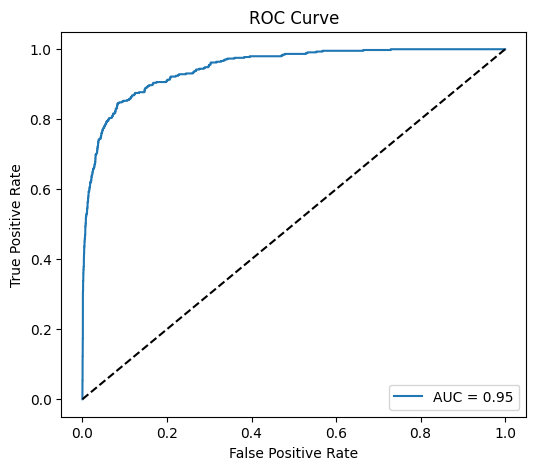

In [33]:
y_proba = model.predict_proba(X_test_tfidf)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


График показывает хорошее качество классификации, что впрочем неудивительно, когда у нас такой большой дисбаланс классов

---

## **Precision-Recall AUC**

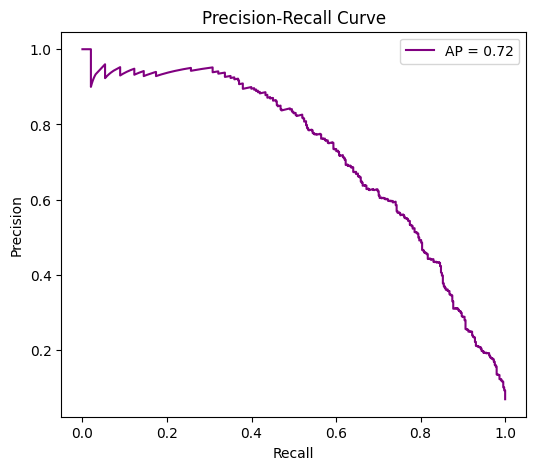

In [34]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_prec = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {avg_prec:.2f}", color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.show()

**PR-Curve** — это график, который отображает зависимость Precision от Recall для различных пороговых значений классификации

Слева (recall ≈ 0–0.4) у нас precision ≈ 0.9–0.95. Если мы ловим только самые уверенные срабатывания, почти все, что модель находит — действительно класс 1.

Дальше, когда мы двигаемся вправо:

- при recall ≈ 0.6 precision всё ещё ≈ 0.75

- при recall ≈ 0.8 precision падает к ≈ 0.45

- при recall → 1.0 precision уходит к нулю (модель начинает кричать «1» почти на все)

Кривая показывает, что модель очень уверенно выявляет редкий класс. AP = 0.72 намного выше случайного уровня. По мере стремления к полному охвату (recall -> 1) точность резко падает, так что оптимальный порог нужно выбирать исходя из того, что важнее — не пропускать случаи или избегать ложных срабатываний.
